## First load the package libraries we are going to use:
Modeling toolkit offers slick ways to define the model and other cool stuff but is not essential.  OrdinarydiffEq provides all the necessary tools. CairoMakie is a package for cool plotting - like ggplot in R.

In [1]:
using ModelingToolkit, OrdinaryDiffEq, CairoMakie

## This version uses ModelingToolkit:
This one has more bells and whistles, like symbolic simplification, automatic jacobians.

First define a trivaial model to illustrate how it works. Then define actual model.

In [2]:
#Define a simple model to illustrate - the logistic.
#define parameters (must specify time)
# this @ notation is part of the ModelingToolKit package.  It is intuitive enough, I guess.

@parameters t r

#define variables. Have to put the (t) after it.
@variables P(t)

#define operator (the modeling toolkit is very general - can define all sorts of operators
D = Differential(t)

#define model. It is a vector (or 'tuple' in julia langauge..) of 'relations' between the rhs and lhs.  
#here there is only one element in the vector.

eqs = [
    D(P) ~ r*P*(1-P)
    ]

#then give the model a 'handle'. 

@named sys = ODESystem(eqs)

Model sys with 1 equations
States (1):
  P(t)
Parameters (1):
  r

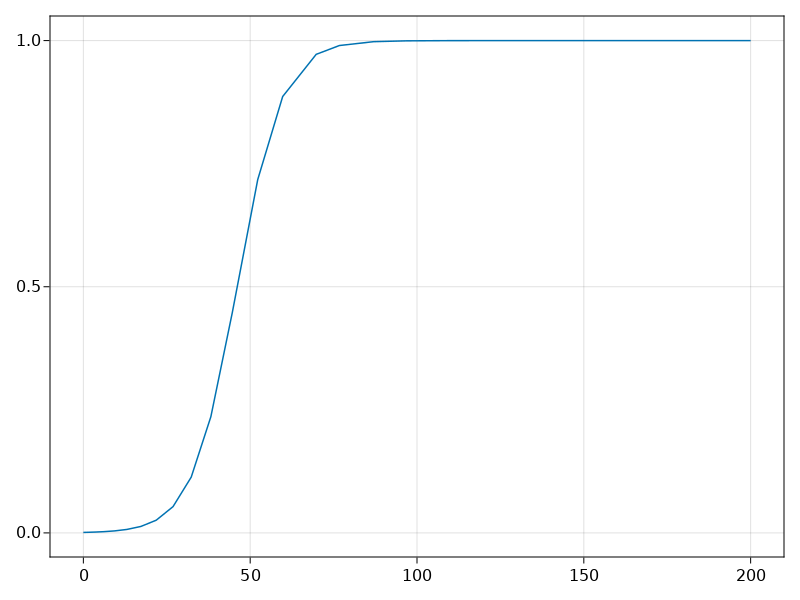

In [3]:
#Then set the initial conditions, parameter vector and integration interval.

#This arrow notatin is, again, part of the modeling tool kit 

u0=[P => 0.001];
p=[r => 0.15,];
tspan=(0.0,200.0);

#Define the problem and solve it.

prob=ODEProblem(sys,u0,tspan,p);
sol=solve(prob,Tsit5());

#and then plot it.....
#Note, for efficient memory allocation the output from
#solve is a a time vector, sol.t, and a vector of 
#vectors of the solution over time, sol.u.  So you 
#need to take care with the indexing. 

#here is one way:

lines(sol.t,[u[1] for u in sol.u])

#here is another.

lines(sol.t,sol[1,:])

#I know this doesn't make sense - i.e. whiy isn't it 
#sol.u[:,1]


In [5]:
lines(sol.t,sol[1,:])

LoadError: UndefVarError: sol not defined

## Now build the real model

In [4]:
# Define the model.........

@parameters t r₁ Kp₁ r₂ Kp₂ δ₁ δ₂ σ₁ σ₂ s₁ s₂
@parameters er₁ er₂ u α α₁ α₂ a₁ a₂ G₀ G₁

@variables P₁(t) P₂(t) K₁(t) K₂(t) G(t)

θ(x)=x^2/(0.0001+x^2)
@register θ(x)

#economic output

#industrial output regime

Yi₁ = a₁*(θ(K₁)^α₁)*(P₁^(1-α₁))
Yi₂ = a₂*(θ(K₂)^α₂)*(P₂^(1-α₂))

#= background production regime (labor based production)
is given by ab₁P₁ but we assume the multiplier is 1. We then
use the threshold function to switch to industrical production
only when it is more productive than the backdrop technology.=#

Y₁ = P₁ + θ(Yi₁ - P₁)*(Yi₁ - P₁)
Y₂ = P₂ + θ(Yi₂ - P₂)*(Yi₂ - P₂)

# Climate damages

dmg₁ = σ₁*exp(G-G₁)
dmg₂ = σ₂*exp(G-G₁)


D = Differential(t)

eqs = [
    D(P₁) ~ r₁*P₁*(1 - P₁/Kp₁),
    D(P₂) ~ r₂*P₂*(1 - P₂/Kp₂),
    D(K₁) ~  s₁*Y₁ - δ₁*K₁ - dmg₁*K₁,
    D(K₂) ~  s₂*Y₂ - δ₂*K₂ - dmg₂*K₂,
    D(G)  ~  er₁*Y₁ + er₂*Y₂ - u*(G-2.8) + α*θ(G-G₀)
    ]

@named sys = ODESystem(eqs)

Model sys with 5 equations
States (5):
  P₁(t)
  P₂(t)
  K₁(t)
  K₂(t)
  G(t)
Parameters (20):
  r₁
  Kp₁
  Kp₂
  r₂
  s₁
  σ₁
⋮

In [9]:
#Then set the initial conditions, parameter vector and integration interval.

# assign values to parameters
p=[r₁=>0.038, Kp₁=>1.5, r₂=>0.042, Kp₂=>9.7, δ₁=>0.5, δ₂=>1.5, σ₁=>0.03, σ₂=>0.03, s₁=>0.25, s₂=>0.21, er₁=>0.0004, er₂=>0.0004, u=>0.0025, α=>0.1, α₁=>0.5, α₂=>0.5, a₁=>2.7, a₂=>1.7, G₁=>5, G₀=>20
]

#set initial conditions

u0=[P₁=>0.24,P₂=>0.24,K₁=>0,K₂=>0,G=>2.8]

#set time span for integrating the system

tspan=(0.0,5.0);

# set up the problem

prob=ODEProblem(sys,u0,tspan,p);

# solve it

sol=solve(prob,Tsit5());


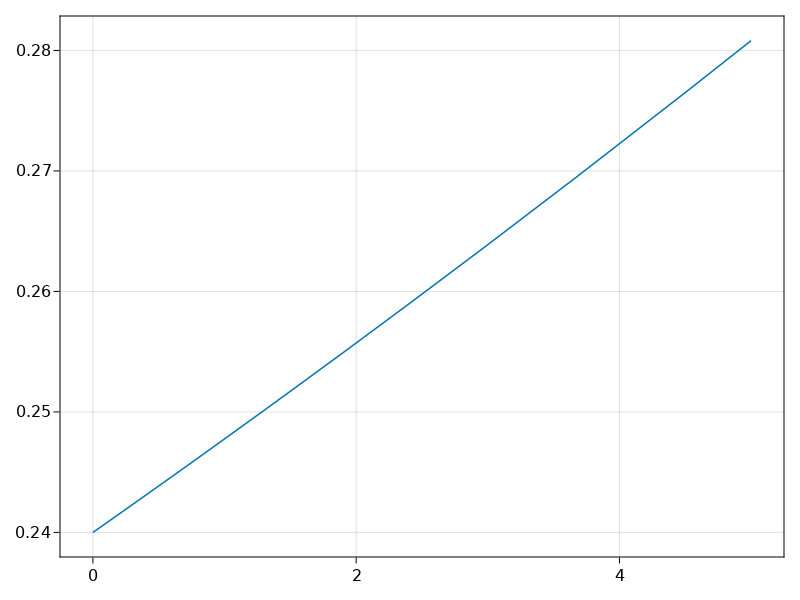

In [31]:
lines(sol.t,sol[1,:])

In [36]:
lines!(a,sol.t,sol[2,:])

Lines{Tuple{Vector{Point{2, Float32}}}}

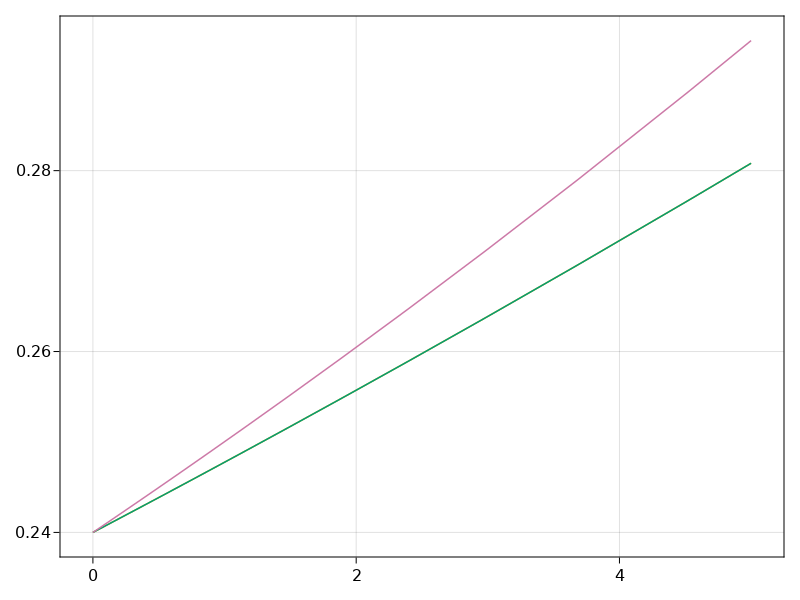

In [37]:
f

In [25]:
sol[2,:]

19-element Vector{Float64}:
 0.24
 0.24089181909701826
 0.241482218982717
 0.24205088802937053
 0.24253732622720361
 0.2430738698760373
 0.24383232831445167
 0.24449228855254146
 0.245161437030307
 0.2467659576411928
 0.24861484098283668
 0.25159813226636724
 0.2550012611573886
 0.25939918666346107
 0.26463456992675877
 0.27111014748888407
 0.27897032547271466
 0.28875907333417283
 0.2943807060446393

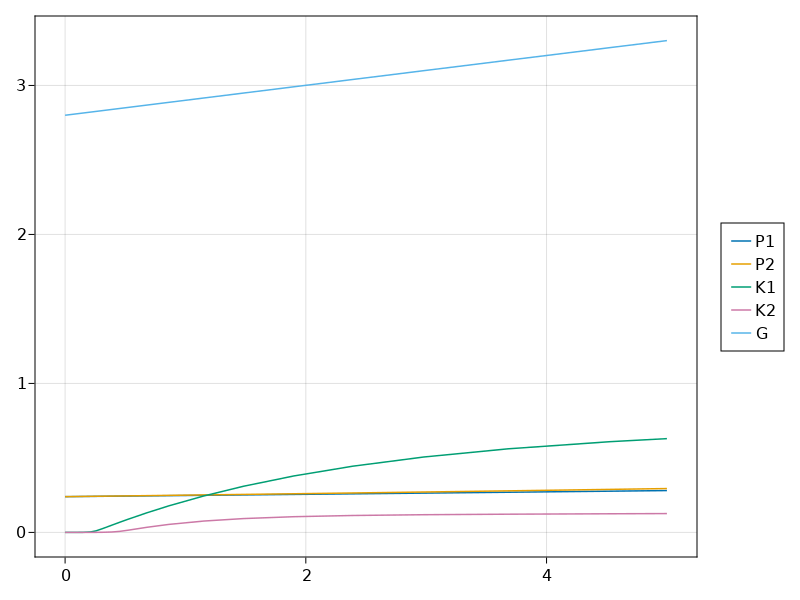

In [40]:
#Now set up the visualization

#first create a figure object (viewport)
f=Figure()

#choose the axis format/attributes for the viewport
a=Axis(f[1,1])

#define the plots to show
h1=lines!(a,sol.t,sol[1,:])
h2=lines!(a,sol.t,sol[2,:])
h3=lines!(a,sol.t,sol[3,:])
h4=lines!(a,sol.t,sol[4,:])
h5=lines!(a,sol.t,sol[5,:])

#set the legend
Legend(f[1,2],[h1,h2,h3,h4,h5],["P1","P2","K1","K2","G"])

#show f
f